This notebook contains code to perform stance mining on tweets related to Neimann v Carlsen over 09/05 to 10/22. It also contains visualizations and analysis for the same.

For best reproduciblity, run this notebook in Google Colab.

# Install required libraries

In [ ]:
!pip install tldextract
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 2.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.3 MB/s 
     |████████████████████████████████| 182 kB 45.5 MB/s 
     |████████████████████████████████| 7.6 MB 64.8 MB/s 


# Importing required libraries

In [ ]:
import re
import ast
import time
import string
import requests
import tldextract
import numpy as np
import pandas as pd
from PIL import Image
from datetime import datetime
from collections import Counter
from nltk.corpus import stopwords
from transformers import pipeline
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Importing Data

In [ ]:
df1 = pd.read_csv('chessTweets_S04-S10.csv', encoding = 'UTF-8')
df2 = pd.read_csv('chessTweets_S11-S17.csv', encoding = 'UTF-8')
df3 = pd.read_csv('chessTweets_S18-S24.csv', encoding = 'UTF-8')
df4 = pd.read_csv('chessTweets_S25-O01.csv', encoding = 'UTF-8')
df5 = pd.read_csv('chessTweets_O02-O08.csv', encoding = 'UTF-8')
df6 = pd.read_csv('chessTweets_O09-O15.csv', encoding = 'UTF-8')
df7 = pd.read_csv('chessTweets_O16-O22.csv', encoding = 'UTF-8')

In [ ]:
tweetsDF = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index = True).drop(['Unnamed: 0', 'TcoOutlinks'], axis = 1)
tweetsDF.shape

(74042, 9)

In [ ]:
tweetsDF

,ID,DateTime,Username,Text,Retweets,Likes,Hashtags,MentionedUsers,Outlinks
0,1568727171585437697,2022-09-10 22:24:37+00:00,SamuelParker05,@invalid_r @GMHikaru @GmNaroditsky @HansMokeNi...,0,0,NaN,"[User(username='invalid_r', id=110734390004853...",NaN
1,1568713043990745088,2022-09-10 21:28:29+00:00,Addio76414081,@bank0l3 @brijwhiz @GrandChessTour @ChrisBirdI...,1,0,NaN,"[User(username='bank0l3', id=273344048, displa...",NaN
2,1568708722880307203,2022-09-10 21:11:19+00:00,GMLucasStrick,@chesscom @DanielRensch @GothamChess @GmNarodi...,0,0,NaN,"[User(username='chesscom', id=20745074, displa...",NaN
3,1568702278286323712,2022-09-10 20:45:42+00:00,khalNERO1,@chess24com Maybe Hans did cheat🌝🌝,0,0,NaN,"[User(username='chess24com', id=1617972740, di...",NaN
4,1568665398350053376,2022-09-10 18:19:10+00:00,JasperRenema,Did Hans Niemann cheat? https://t.co/ui3W9IDgri,0,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
74037,1583191390548201472,2022-10-20 20:20:16+00:00,qt314fromky,@evilstrap @KryptiskeKjell @brianhc @HansMokeN...,0,1,NaN,"[User(username='evilstrap', id=18611463, displ...",NaN
74038,1583647312454172672,2022-10-22 02:31:56+00:00,DrAdrianLee,@sunmaster14 @TarjeiJS @CoetseeDarren @5mintil...,0,0,NaN,"[User(username='sunmaster14', id=2190549734, d...",NaN
74039,1583562743658868763,2022-10-21 20:55:53+00:00,pythonprimes,@noamb424 @AkivaMCohen It doesn’t say he cheat...,0,1,NaN,"[User(username='noamb424', id=82188614, displa...",NaN
74040,1583430613528608768,2022-10-21 12:10:51+00:00,gabrielerob,@DPruess Was it banning him from chessdotcom a...,0,7,NaN,"[User(username='DPruess', id=393457572, displa...",NaN


# Data Pre-processing

In [ ]:
# Splitting date and time
tweetsDF['Date'] = pd.to_datetime(tweetsDF['DateTime']).dt.date
tweetsDF['Time'] = pd.to_datetime(tweetsDF['DateTime']).dt.time
tweetsDF = tweetsDF.drop(['DateTime'], axis = 1)

In [ ]:
# Extracting users mentioned in the tweets.
def findUsername(text):
    word = re.findall(r'(?<=@)\w+', text)
    return ", ".join(word)

tweetsDF['MentionedUsers'] = tweetsDF['Text'].apply(lambda x: findUsername(x))

In [ ]:
# Extracting hashtags mentioned in the tweets.
def findHashtags(text):
    word = re.findall(r'(?<=#)\w+', text)
    return ", ".join(word)

tweetsDF['Hashtags'] = tweetsDF['Text'].apply(lambda x: findHashtags(x))

In [ ]:
# Extracting domain mentioned in the tweets.
#def findDomain(text):
    #word = tldextract.extract(ast.literal_eval(text))
    #return ", ".join(word)

#tweetsDF['Outlinks'] = tweetsDF['Outlinks'].apply(lambda x: findDomain(x))
#tweetsDF['Outlinks'].convert_dtypes(convert_string=True)
#print(tweetsDF.at[tweetsDF.index[12232],'Outlinks'])

extracted = tldextract.extract('http://twitch.tv/chicago670thescore')
"{}".format(extracted.domain)

'twitch'

In [ ]:
# Removing usernames from the tweets.
def removeUsername(text):
  text = re.sub(r'@[^\s]+', '', text)
  return text

tweetsDF['Text'] = tweetsDF['Text'].apply(lambda x: removeUsername(x))

In [ ]:
# Removing hashtags from the tweets.
def removeHashtag(text):
  text = re.sub(r'#[^\s]+', '', text)
  return text

tweetsDF['Text'] = tweetsDF['Text'].apply(lambda x: removeHashtag(x))

In [ ]:
# Removing links from the tweets.
def removeLinks(text):
  text = re.sub(r'http[^\s]+', '', text)
  return text
 
tweetsDF['Text'] = tweetsDF['Text'].apply(lambda x: removeLinks(x))

In [ ]:
# Removing emojis from the tweets.
def removeEmoji(text):
  text = re.sub(r'[\U00010000-\U0010ffff]', '', text)
  return text

tweetsDF['Text'] = tweetsDF['Text'].apply(lambda x: removeEmoji(x))

In [ ]:
# Removing extra white spaces from the tweets.
def removeExtraSpaces(text):
  text = re.sub(r'[\s\s+]', ' ', text)
  text = text.strip()
  return text

tweetsDF['Text'] = tweetsDF['Text'].apply(lambda x: removeExtraSpaces(x))

In [ ]:
# Removing spammed text from the tweets
tweetsDF = tweetsDF.drop_duplicates(subset=['Username', 'Text'])

In [ ]:
tweetsDF

,ID,Username,Text,Retweets,Likes,Hashtags,MentionedUsers,Outlinks,Date,Time
0,1568727171585437697,SamuelParker05,"''fam??'' wtf are you, 6 years old? Did you no...",0,0,,"invalid_r, GMHikaru, GmNaroditsky, HansMokeNie...",NaN,2022-09-10,22:24:37
1,1568713043990745088,Addio76414081,But I do think that more precautions and cheat...,1,0,,"bank0l3, brijwhiz, GrandChessTour, ChrisBirdIA",NaN,2022-09-10,21:28:29
2,1568708722880307203,GMLucasStrick,Hans about to cheat to another W. But in reali...,0,0,,"chesscom, DanielRensch, GothamChess, GmNaroditsky",NaN,2022-09-10,21:11:19
3,1568702278286323712,khalNERO1,Maybe Hans did cheat,0,0,,chess24com,NaN,2022-09-10,20:45:42
4,1568665398350053376,JasperRenema,Did Hans Niemann cheat?,0,2,,,NaN,2022-09-10,18:19:10
...,...,...,...,...,...,...,...,...,...,...
74037,1583191390548201472,qt314fromky,Nor did anyone accuse him of cheating him OTB ...,0,1,,"evilstrap, KryptiskeKjell, brianhc, HansMokeNi...",NaN,2022-10-20,20:20:16
74038,1583647312454172672,DrAdrianLee,Whether his belief that HN cheated in the Sinq...,0,0,,"sunmaster14, TarjeiJS, CoetseeDarren, 5mintill...",NaN,2022-10-22,02:31:56
74039,1583562743658868763,pythonprimes,It doesn’t say he cheated at the sinquefield c...,0,1,,"noamb424, AkivaMCohen",NaN,2022-10-21,20:55:53
74040,1583430613528608768,gabrielerob,Was it banning him from chessdotcom after the ...,0,7,,DPruess,NaN,2022-10-21,12:10:51


# Data Exploration

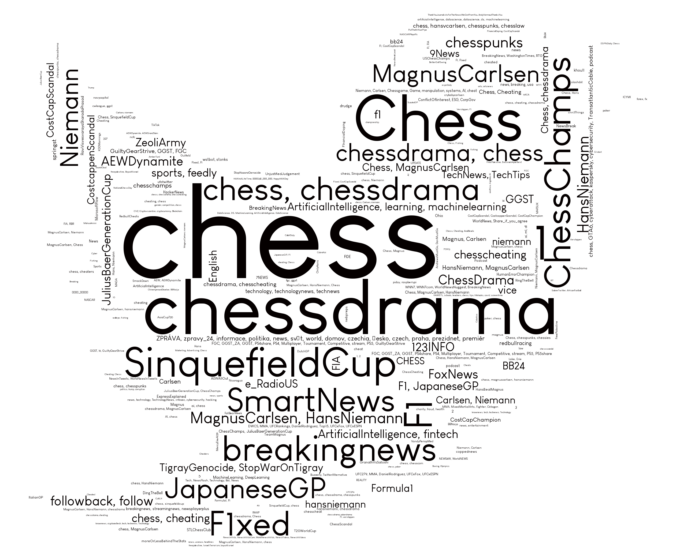

In [ ]:
#generate a word cloud for the top 300 hashtags from the dataset. 
data = tweetsDF['Hashtags'].value_counts().to_dict()

stopwords = set(STOPWORDS)
more_stopwords = {'SKZCODE', 'F1', 'F1xed', 'dtype', 'Name', 'Formula1', 'object', 'Length', 'Hashtags', '1', 'SUFC'}
stopwords = stopwords.union(more_stopwords)

mask = np.array(Image.open("wc.png"))

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud = WordCloud(mask = mask, stopwords = stopwords ,font_path = 'Louis George Cafe.ttf', background_color="white", width=3000, height=2000, max_words=300, collocations=False).generate_from_frequencies(data)
wordcloud.recolor(color_func = black_color_func)

plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

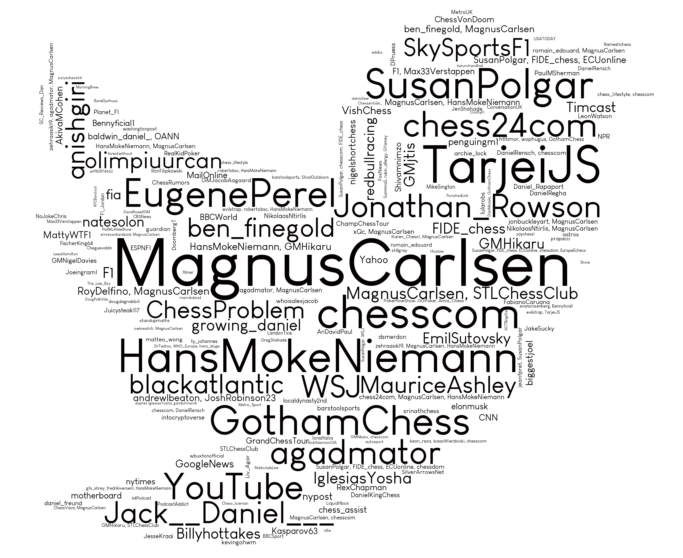

In [ ]:
#generate a word cloud for the top 200 mentioned users in the data.
data = tweetsDF['MentionedUsers'].value_counts().to_dict()

stopwords = set(STOPWORDS)
more_stopwords = {'SKZCODE', 'F1', 'F1xed', 'dtype', 'Name', 'Formula1', 'object', 'Length', 'Hashtags', '1', 'SUFC'}
stopwords = stopwords.union(more_stopwords)

mask = np.array(Image.open("wc.png"))

def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

wordcloud = WordCloud(mask = mask, stopwords = stopwords ,font_path = 'Louis George Cafe.ttf', background_color="white", width=3000, height=2000, max_words=200, collocations=False).generate_from_frequencies(data)
wordcloud.recolor(color_func = black_color_func)

plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Stance Analysis

In [ ]:
#build the pipeline with BART
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Example for how it works.
startTime = time.time()

sentence = "Hans Niemann is a cheater"
class_labels = ['against', 'for', 'neutral']
print(classifier(sentence, class_labels))

endTime = time.time()
print("Time Taken: {} Seconds.".format(round((endTime - startTime), 2)))

{'sequence': 'Hans Niemann is a cheater', 'labels': ['against', 'for', 'neutral'], 'scores': [0.7740108966827393, 0.2199925035238266, 0.0059965536929667]}
Time Taken: 3.29 Seconds.


In [ ]:
stanceDF = tweetsDF[['ID','Date', 'Username', 'Text']]
df = stanceDF
stanceDF

,ID,Date,Username,Text
0,1568727171585437697,2022-09-10,SamuelParker05,"''fam??'' wtf are you, 6 years old? Did you no..."
1,1568713043990745088,2022-09-10,Addio76414081,But I do think that more precautions and cheat...
2,1568708722880307203,2022-09-10,GMLucasStrick,Hans about to cheat to another W. But in reali...
3,1568702278286323712,2022-09-10,khalNERO1,Maybe Hans did cheat
4,1568665398350053376,2022-09-10,JasperRenema,Did Hans Niemann cheat?
...,...,...,...,...
74037,1583191390548201472,2022-10-20,qt314fromky,Nor did anyone accuse him of cheating him OTB ...
74038,1583647312454172672,2022-10-22,DrAdrianLee,Whether his belief that HN cheated in the Sinq...
74039,1583562743658868763,2022-10-21,pythonprimes,It doesn’t say he cheated at the sinquefield c...
74040,1583430613528608768,2022-10-21,gabrielerob,Was it banning him from chessdotcom after the ...


In [ ]:
# Taking Random 100 smaples to test the model
stanceDF =  stanceDF.sample(n = 100, random_state = None)
stanceDF.head()

,ID,Date,Username,Text
15730,1571935098290962432,2022-09-19,jeff82874662,One of two things has to be true: either 1) Ma...
34541,1576281446045491200,2022-10-01,SAchenar,Imagine using a cheating scandal to make some ...
34335,1576339331383296000,2022-10-01,RandallHead1,Is there any evidence of current cheating in c...
64818,1579032220781924353,2022-10-09,ryancla38086967,Let not take anything away from MV here he was...
9084,1569020093207613443,2022-09-11,wwshutupcom,Yawr saaf pta chal rha wo cheating kr rhy Han


In [ ]:
# defining the class labels
classes = ['supports', 'opposes', 'neutral']
hypothesis = "This test {} to Hans Niemann is a cheater"

In [ ]:
# predicting the labels using the classifier
startTime = time.time()
stanceDF['Labels'] = stanceDF.apply(lambda x: classifier(x.Text, classes,  hypothesis_template = hypothesis, multi_label = True), axis=1)
endTime = time.time()
print("Time Taken: {} minutes.".format(round((endTime - startTime)/60, 2)))

Time Taken: 11.35 minutes.


In [ ]:
# extracting the stance labels and stance probablity scores
stanceDF['Stance'] = stanceDF.apply(lambda row: row['Labels']['labels'][0], axis=1)
stanceDF['Score'] = stanceDF.apply(lambda row: row['Labels']['scores'][0], axis=1)

In [ ]:
stanceDF.head()

,ID,Date,Username,Text,Labels,Stance,Score
15730,1571935098290962432,2022-09-19,jeff82874662,One of two things has to be true: either 1) Ma...,{'sequence': 'One of two things has to be true...,opposes,0.963669
34541,1576281446045491200,2022-10-01,SAchenar,Imagine using a cheating scandal to make some ...,{'sequence': 'Imagine using a cheating scandal...,opposes,0.033279
34335,1576339331383296000,2022-10-01,RandallHead1,Is there any evidence of current cheating in c...,{'sequence': 'Is there any evidence of current...,opposes,0.051879
64818,1579032220781924353,2022-10-09,ryancla38086967,Let not take anything away from MV here he was...,{'sequence': 'Let not take anything away from ...,opposes,0.026450
9084,1569020093207613443,2022-09-11,wwshutupcom,Yawr saaf pta chal rha wo cheating kr rhy Han,{'sequence': 'Yawr saaf pta chal rha wo cheati...,supports,0.981548


In [ ]:
stanceDF.to_csv("stance.csv")

In [ ]:
#dataframe to compare the changes in stance over 09/05 to 10/22
dateDF = stanceDF.groupby([stanceDF['Date'],'Stance']).mean()
dateDF

ID     Score
Date       Stance                          
2022-09-05 opposes   1.566900e+18  0.218282
           supports  1.566860e+18  0.038516
2022-09-06 opposes   1.567142e+18  0.071792
2022-09-07 opposes   1.567585e+18  0.046670
           supports  1.567613e+18  0.050677
2022-09-08 opposes   1.567804e+18  0.545446
2022-09-09 opposes   1.568235e+18  0.567159
2022-09-10 opposes   1.568596e+18  0.370301
           supports  1.568686e+18  0.966469
2022-09-11 opposes   1.568998e+18  0.168788
           supports  1.568944e+18  0.498524
2022-09-12 opposes   1.569273e+18  0.337580
2022-09-13 opposes   1.569765e+18  0.155800
2022-09-14 opposes   1.570148e+18  0.623731
2022-09-17 opposes   1.571149e+18  0.039477
2022-09-18 opposes   1.571534e+18  0.109592
2022-09-19 opposes   1.571952e+18  0.572530
2022-09-20 supports  1.572239e+18  0.022161
2022-09-22 opposes   1.572996e+18  0.197280
           supports  1.572878e+18  0.342685
2022-09-23 opposes   1.573289e+18  0.853919
2022-09-24 opposes   1.573701e+18  0.077766
2022-09-25 opposes   1.574121e+18  0.544741
2022-09-26 opposes   1.574477e+18  0.489715
2022-09-27 opposes   1.574718e+18  0.336975
           supports  1.574774e+18  0.963566
2022-09-28 opposes   1.575129e+18  0.575129
           supports  1.575227e+18  0.998633
2022-09-29 neutral   1.575387e+18  0.921013
           opposes   1.575361e+18  0.930439
2022-10-01 opposes   1.576250e+18  0.171012
           supports  1.576111e+18  0.519831
2022-10-02 opposes   1.576371e+18  0.120851
2022-10-03 supports  1.577017e+18  0.029532
2022-10-04 opposes   1.577273e+18  0.874043
           supports  1.577426e+18  0.859033
2022-10-05 neutral   1.577568e+18  0.209690
           opposes   1.577632e+18  0.331985
           supports  1.577780e+18  0.060939
2022-10-06 neutral   1.577829e+18  0.098660
           opposes   1.577920e+18  0.270612
           supports  1.578028e+18  0.733413
2022-10-07 opposes   1.578349e+18  0.058146
2022-10-08 neutral   1.578743e+18  0.679592
           opposes   1.578872e+18  0.038034
2022-10-09 opposes   1.579089e+18  0.092093
           supports  1.578932e+18  0.155022
2022-10-12 supports  1.580308e+18  0.526259
2022-10-15 opposes   1.581311e+18  0.307631
2022-10-16 opposes   1.581693e+18  0.201593
           supports  1.581690e+18  0.007714
2022-10-18 opposes   1.582272e+18  0.132720
2022-10-19 opposes   1.582667e+18  0.454083
2022-10-20 supports  1.582964e+18  0.444151
2022-10-21 opposes   1.583260e+18  0.783055
           supports  1.583369e+18  0.715566
2022-10-22 opposes   1.583781e+18  0.288138

# From here, it is an attempt to create a timeline based graph for the first week.

In [ ]:
# creating a dataframe of tweets between September 04-10 when Hans was first accused of Cheating
df = pd.read_csv('chessTweets_S04-S10.csv', encoding = 'UTF-8')

In [ ]:
df.head()

,Unnamed: 0,ID,DateTime,Username,Text,Retweets,Likes,Hashtags,MentionedUsers,Outlinks,TcoOutlinks
0,0,1568727171585437697,2022-09-10 22:24:37+00:00,SamuelParker05,@invalid_r @GMHikaru @GmNaroditsky @HansMokeNi...,0,0,NaN,"[User(username='invalid_r', id=110734390004853...",NaN,NaN
1,1,1568713043990745088,2022-09-10 21:28:29+00:00,Addio76414081,@bank0l3 @brijwhiz @GrandChessTour @ChrisBirdI...,1,0,NaN,"[User(username='bank0l3', id=273344048, displa...",NaN,NaN
2,2,1568708722880307203,2022-09-10 21:11:19+00:00,GMLucasStrick,@chesscom @DanielRensch @GothamChess @GmNarodi...,0,0,NaN,"[User(username='chesscom', id=20745074, displa...",NaN,NaN
3,3,1568702278286323712,2022-09-10 20:45:42+00:00,khalNERO1,@chess24com Maybe Hans did cheat🌝🌝,0,0,NaN,"[User(username='chess24com', id=1617972740, di...",NaN,NaN
4,4,1568665398350053376,2022-09-10 18:19:10+00:00,JasperRenema,Did Hans Niemann cheat? https://t.co/ui3W9IDgri,0,2,NaN,NaN,NaN,NaN


In [ ]:
# converting the DateTime column into a datetime datatype from string datatype
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d')

In [ ]:
 # Creating dataframes containng tweets for each date(Sept04-Sept10)
df1 = df.loc[(df['DateTime'] >= '2022-09-04') & (df['DateTime'] < '2022-09-05')]
df2 = df.loc[(df['DateTime'] >= '2022-09-05') & (df['DateTime'] < '2022-09-06')]
df3 = df.loc[(df['DateTime'] >= '2022-09-06') & (df['DateTime'] < '2022-09-07')]
df4 = df.loc[(df['DateTime'] >= '2022-09-07') & (df['DateTime'] < '2022-09-08')]
df5 = df.loc[(df['DateTime'] >= '2022-09-08') & (df['DateTime'] < '2022-09-09')]
df6 = df.loc[(df['DateTime'] >= '2022-09-09') & (df['DateTime'] < '2022-09-10')]
df7 = df.loc[(df['DateTime'] >= '2022-09-10') & (df['DateTime'] < '2022-09-11')]  

In [ ]:
# randomly selecting a sample of 100 tweets for each date(Sept04-Sept10)
df1_stance =  df1.sample(n = 100, random_state = None)
df2_stance =  df2.sample(n = 100, random_state = None)
df3_stance =  df3.sample(n = 100, random_state = None)
df4_stance =  df4.sample(n = 100, random_state = None)
df5_stance =  df5.sample(n = 100, random_state = None)
df6_stance =  df6.sample(n = 100, random_state = None)
df7_stance =  df7.sample(n = 100, random_state = None)

In [ ]:
# Concatenating each of the stance dataframes to create a dataframe of 700 tweets
df_stance = pd.concat([df1_stance, df2_stance, df3_stance, df4_stance, df5_stance, df6_stance, df7_stance], ignore_index = True)
df_stance.tail()

,Unnamed: 0,ID,DateTime,Username,Text,Retweets,Likes,Hashtags,MentionedUsers,Outlinks,TcoOutlinks
695,8919,1568534877246472193,2022-09-10 09:40:31+00:00,loreval8,@RByykkonen @agadmator The question is: did he...,0,1,NaN,"[User(username='RByykkonen', id=2988624911, di...",NaN,NaN
696,14144,1568658012356907010,2022-09-10 17:49:49+00:00,invalid_r,@GMHikaru @GmNaroditsky @GMHikaru for a well e...,0,5,NaN,"[User(username='GMHikaru', id=64324543, displa...",NaN,NaN
697,2250,1568394203524120576,2022-09-10 00:21:32+00:00,wagonomics,@wophugus Of course that would all be just as ...,0,0,NaN,"[User(username='wophugus', id=113587399, displ...",NaN,NaN
698,10723,1568453501474275328,2022-09-10 04:17:09+00:00,MiscreantAs,@SueAlberici @jerseelaundry @shnbrdy @flower_a...,0,3,NaN,"[User(username='SueAlberici', id=1365370297835...",NaN,NaN
699,4502,1568560078713913347,2022-09-10 11:20:39+00:00,Abiigaiiiiil,"@Sabby_Han @ycsm1n Knows Elizabeth, she probab...",0,0,NaN,"[User(username='Sabby_Han', id=112180005975285...",NaN,NaN


In [ ]:
# defining the class labels
classes = ['supports', 'opposes', 'neutral']
hypothesis = "This test {} to Hans Niemann is a cheater"

In [ ]:
# predicting the class labels using the classifier
startTime = time.time()
df_stance['Labels'] = df_stance.apply(lambda x: classifier(x.Text, classes,  hypothesis_template = hypothesis, multi_label = True), axis=1)
endTime = time.time()
print("Time Taken: {} minutes.".format(round((endTime - startTime)/60, 2)))

Time Taken: 44.38 minutes.


In [ ]:
df_stance.head()

,Unnamed: 0,ID,DateTime,Username,Text,Retweets,Likes,Hashtags,MentionedUsers,Outlinks,TcoOutlinks,Labels
0,18990,1566499625695166466,2022-09-04 18:53:09+00:00,DampQuiche285,@Max33Verstappen @redbullracing You're well on...,0,2,NaN,"[User(username='Max33Verstappen', id=556260847...",NaN,NaN,{'sequence': '@Max33Verstappen @redbullracing ...
1,11777,1566349937977266176,2022-09-04 08:58:21+00:00,tmd_daniel,Please how do we locate this abnormal woman wi...,0,0,NaN,NaN,['https://twitter.com/Mbahdeyforyou/status/156...,['https://t.co/g1Jq7pfBvP'],{'sequence': 'Please how do we locate this abn...
2,12018,1566547352869289985,2022-09-04 22:02:48+00:00,TheCynicalHun,Insiders speak out about how Daniel Andrews pu...,4,11,NaN,NaN,['https://mol.im/a/11166917'],['https://t.co/xwhUIzwCqQ'],{'sequence': 'Insiders speak out about how Dan...
3,18109,1566407321768665089,2022-09-04 12:46:22+00:00,BladeStormElite,"Congratz on our boy, @Shen_blaze. On the Dub i...",2,2,NaN,"[User(username='Shen_blaze', id=258568142, dis...",['https://clips.twitch.tv/OpenArtsyTubersChefF...,['https://t.co/AL8XGLtvyH'],"{'sequence': 'Congratz on our boy, @Shen_blaze..."
4,18485,1566379839430557697,2022-09-04 10:57:10+00:00,BolajiAdeniji1,@RayonGreenfiel4 Roman can't win a math withou...,0,0,NaN,NaN,NaN,NaN,{'sequence': '@RayonGreenfiel4 Roman can't win...


In [ ]:
# extracting the stance labels and stance probablity scores.
df_stance['Stance'] = df_stance.apply(lambda row: row['Labels']['labels'][0], axis=1)
df_stance['Score'] = df_stance.apply(lambda row: row['Labels']['scores'][0], axis=1)
df_stance.drop(['Unnamed: 0', 'Retweets', 'Likes', 'Hashtags', 'MentionedUsers', 'Outlinks','TcoOutlinks'], axis = 1)

,ID,DateTime,Username,Text,Labels,Stance,Score
0,1566499625695166466,2022-09-04 18:53:09+00:00,DampQuiche285,@Max33Verstappen @redbullracing You're well on...,{'sequence': '@Max33Verstappen @redbullracing ...,opposes,0.007358
1,1566349937977266176,2022-09-04 08:58:21+00:00,tmd_daniel,Please how do we locate this abnormal woman wi...,{'sequence': 'Please how do we locate this abn...,opposes,0.010515
2,1566547352869289985,2022-09-04 22:02:48+00:00,TheCynicalHun,Insiders speak out about how Daniel Andrews pu...,{'sequence': 'Insiders speak out about how Dan...,opposes,0.206047
3,1566407321768665089,2022-09-04 12:46:22+00:00,BladeStormElite,"Congratz on our boy, @Shen_blaze. On the Dub i...","{'sequence': 'Congratz on our boy, @Shen_blaze...",neutral,0.010297
4,1566379839430557697,2022-09-04 10:57:10+00:00,BolajiAdeniji1,@RayonGreenfiel4 Roman can't win a math withou...,{'sequence': '@RayonGreenfiel4 Roman can't win...,opposes,0.224233
...,...,...,...,...,...,...,...
695,1568534877246472193,2022-09-10 09:40:31+00:00,loreval8,@RByykkonen @agadmator The question is: did he...,{'sequence': '@RByykkonen @agadmator The quest...,opposes,0.297552
696,1568658012356907010,2022-09-10 17:49:49+00:00,invalid_r,@GMHikaru @GmNaroditsky @GMHikaru for a well e...,{'sequence': '@GMHikaru @GmNaroditsky @GMHikar...,opposes,0.137932
697,1568394203524120576,2022-09-10 00:21:32+00:00,wagonomics,@wophugus Of course that would all be just as ...,{'sequence': '@wophugus Of course that would a...,opposes,0.852331
698,1568453501474275328,2022-09-10 04:17:09+00:00,MiscreantAs,@SueAlberici @jerseelaundry @shnbrdy @flower_a...,{'sequence': '@SueAlberici @jerseelaundry @shn...,supports,0.113756


In [ ]:
# grouping the tweets based on counts of stance labels over Sept4-Sept10
dd = df_stance.groupby([df_stance['DateTime'].dt.date,'Stance']).Stance.count()
dd

DateTime    Stance  
2022-09-04  neutral      9
            opposes     62
            supports    29
2022-09-05  neutral      6
            opposes     71
            supports    23
2022-09-06  neutral      6
            opposes     70
            supports    24
2022-09-07  neutral      5
            opposes     77
            supports    18
2022-09-08  neutral      3
            opposes     74
            supports    23
2022-09-09  neutral      7
            opposes     71
            supports    22
2022-09-10  neutral     11
            opposes     71
            supports    18
Name: Stance, dtype: int64

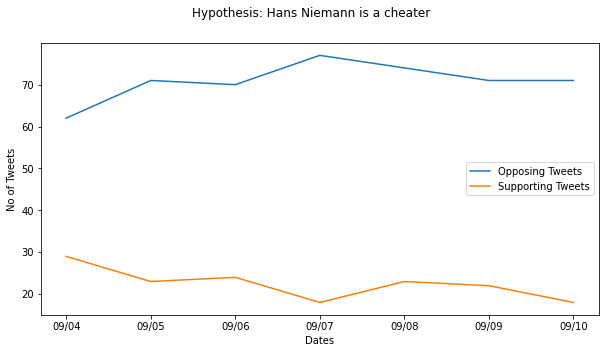

In [ ]:
# Creating a plot to find the trends in stance counts for tweets over September 04-September 10

import matplotlib.pyplot as plt
dd = df_stance.groupby([df_stance['DateTime'].dt.date,'Stance']).Stance.count()
count=0
l_opp,l_sup = [],[]
for idx,value in enumerate(dd):
  if(count%3==1):
    l_opp.append(value)
  if(count%3==2):
    l_sup.append(value)
  count+=1

ypoints_opp = np.array(l_opp)
ypoints_sup = np.array(l_sup)
x = df_stance['DateTime'].dt.date.unique()
x_l = []
for i in x:
  x_l.append(i.strftime("%m/%d/%Y")[:5])
x_l = sorted(x_l)
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
f.suptitle('Hypothesis: Hans Niemann is a cheater')
plt.plot(x_l, ypoints_opp,label='Opposing Tweets')
plt.plot(x_l, ypoints_sup,label='Supporting Tweets')
plt.xlabel('Dates')
plt.ylabel('No of Tweets')
plt.legend()
plt.show()

In [ ]:
df_stance.to_csv("df_stance.csv")